#### Student Name: Ashley Newman
#### Student ID: 806092

# Assignment 6

### PCA with Linear Autoencoder

Instructions: 

* This notebook is an interactive assignment; please read and follow the instructions in each cell. 

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook as a PDF.

* Make sure to mark the page with your solution for each problem on Gradescope. Any problems without the correct pages marked may receive a score of 0. 




In [1]:

!pip install tensorflow

!pip install keras

!pip install --upgrade protobuf

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=23ea454850670d3d194e78cdd25baa889f288ae27240ce7c73a4bb39d52d4ff0
  Stored in directory: c:\users\itay private\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor


In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
from numpy.linalg import svd
from scipy.stats.mstats import gmean
from matplotlib import rcParams
import scipy
import os
import sys
import glob
import pickle
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Lambda
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.disable_v2_behavior()


import warnings
warnings.filterwarnings('ignore')

# PCA with a Linear Autoencoder

In this problem, we will practice using basic neural network procedures by running an autoencoder network.
This network is implemented in TensorFlow (essentially Keras with an expanded toolset); the functions we call are nearly identical to those you will see in Keras. 

Let's create a sin+noise signal to use as input to our network:

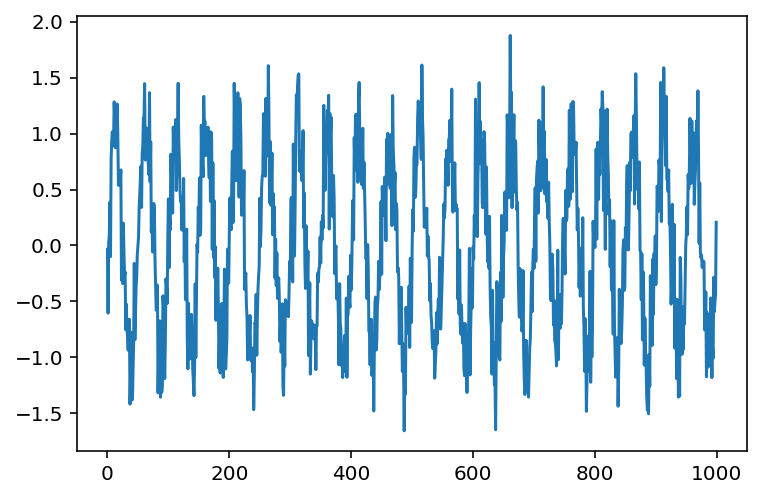

In [51]:
f0 = 200
fs = 10000
T = 3
Ns = fs*T

def buffer(input_data, sample_rate, window_size, hop_size):
    output = np.array([input_data[i:i+window_size] for i in range(0, len(input_data)-window_size, hop_size)])
    return output.T

s = np.sin(2*np.pi*f0*np.arange(Ns)/fs)

n = np.random.randn(Ns)

x = s + 0.3*n 

plt.plot(x[:1000])
wavfile.write('out2.wav', fs, x)
xmat = buffer(x,fs,400,200)

Here we create an AE with 2 hidden layers. 

This neural network is implemented in TensorFlow. 

Please review the code cells below, and answer the questions that follow. 

In [39]:
n_inputs = np.shape(xmat)[0]  #400
n_hidden = 2 

learning_rate = 0.01 

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
W = tf.Variable(tf.truncated_normal(stddev=.1, shape =[n_inputs,n_hidden]))

hidden = tf.matmul(X,W)
outputs = tf.matmul(hidden,tf.transpose(W))

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

C:\Users\Itay Private\anaconda3\envs\ashenv\lib\site-packages\tensorflow\python\client\session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


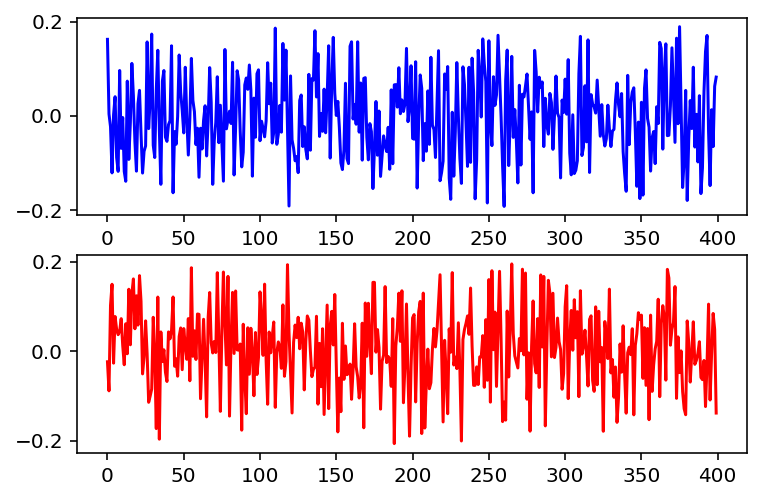

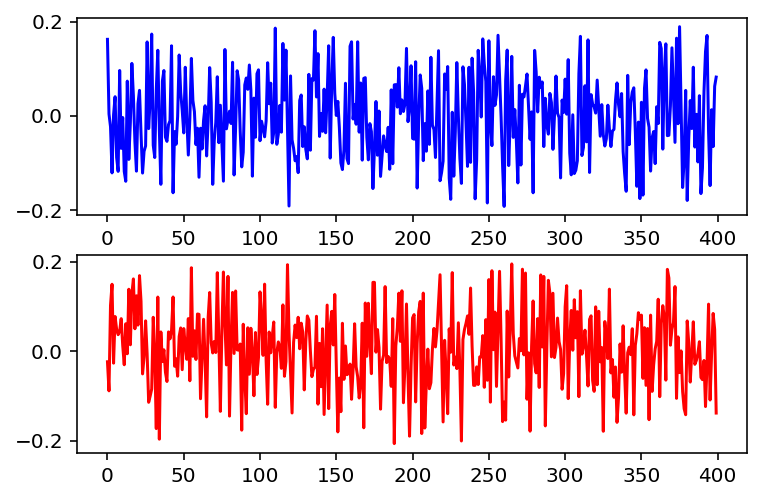

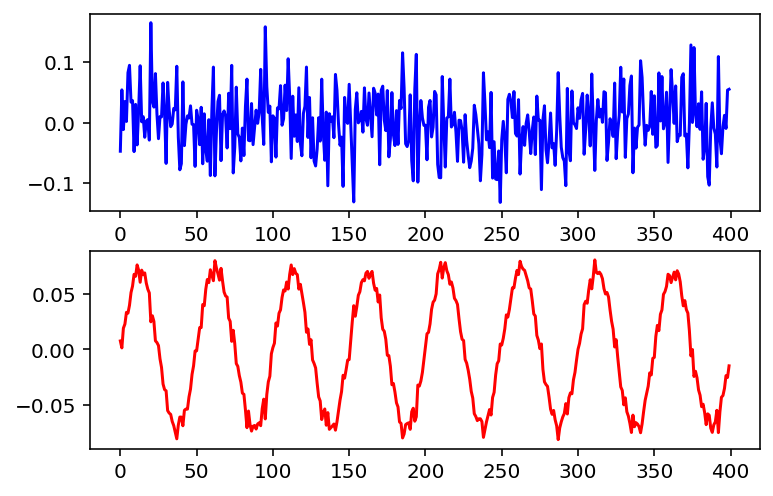

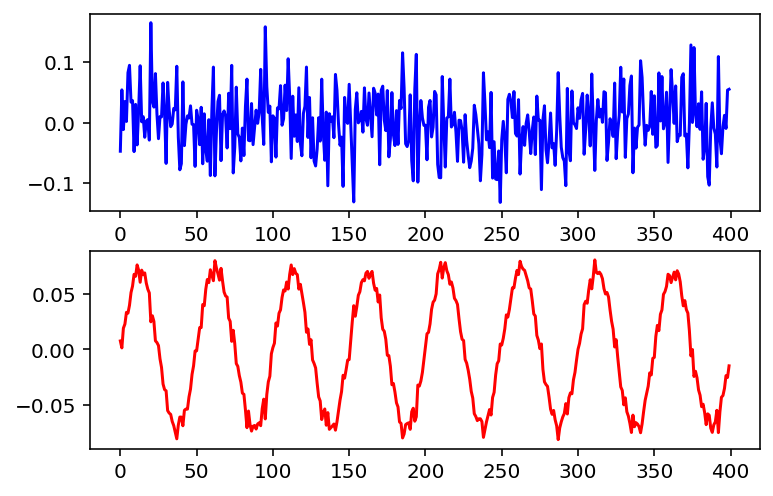

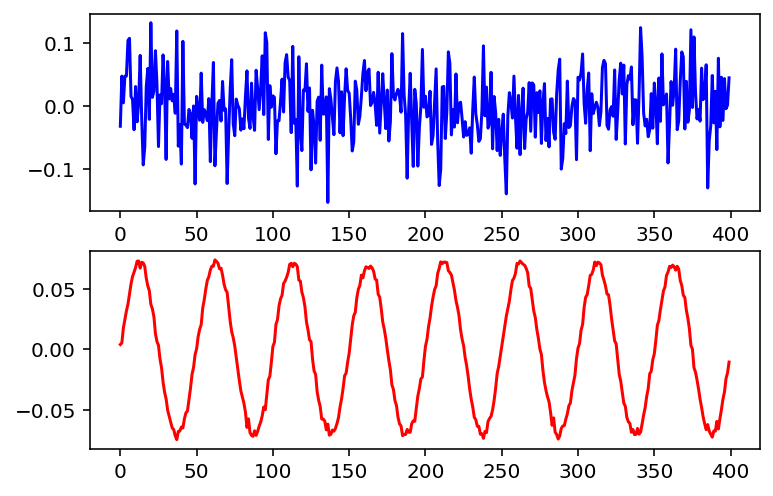

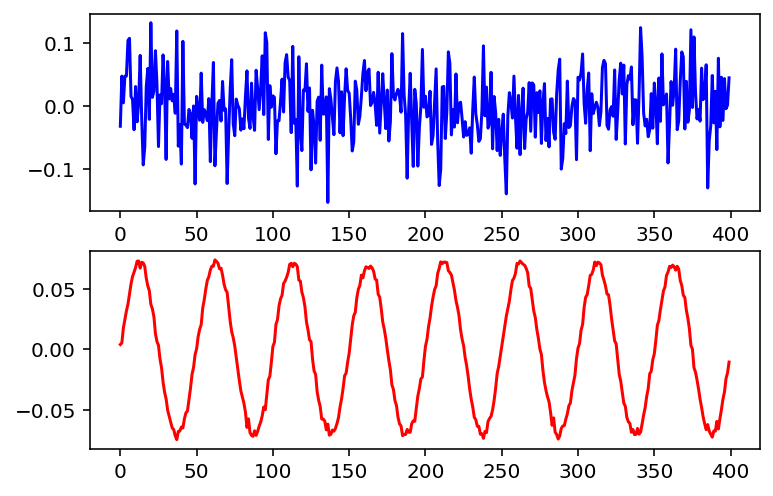

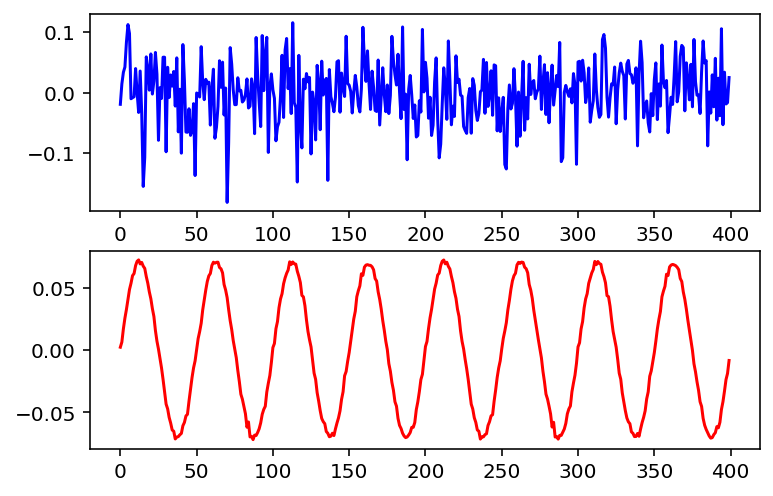

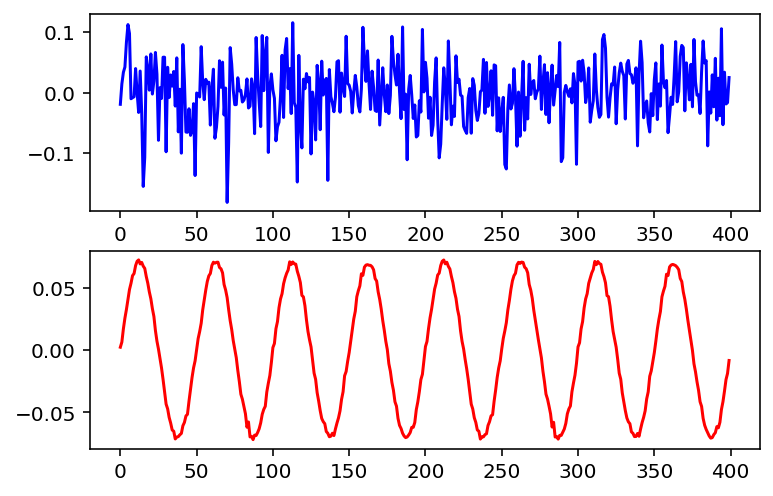

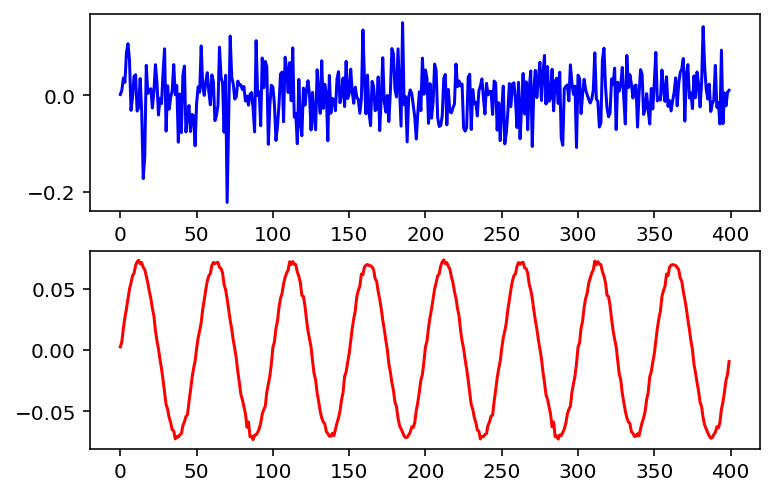

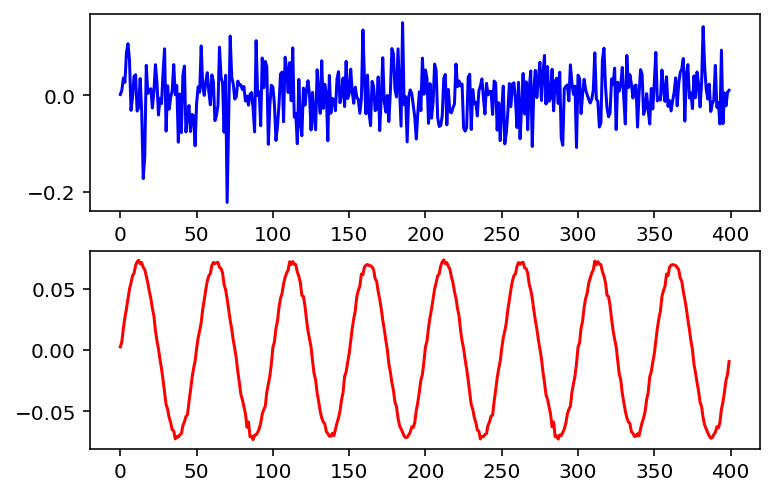

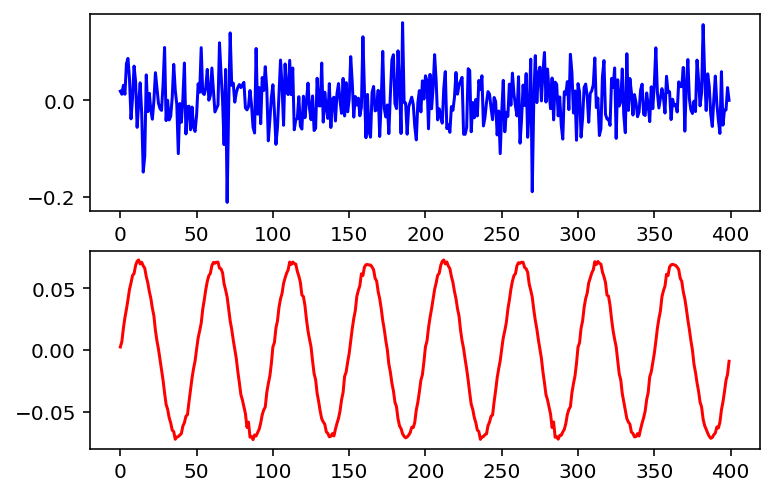

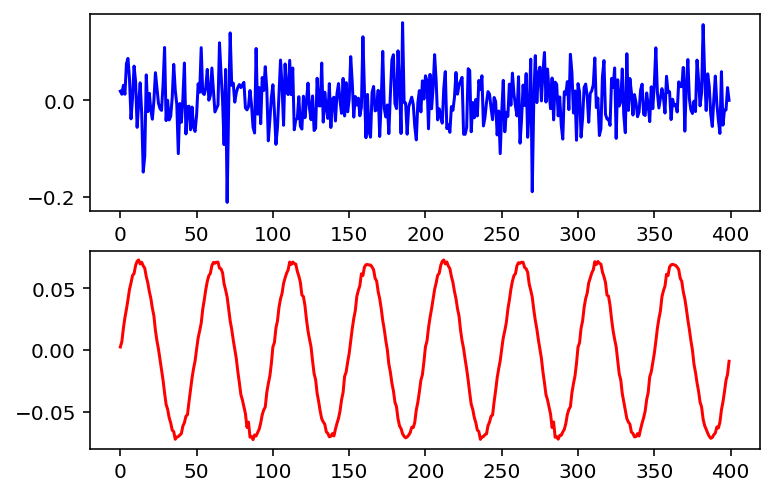

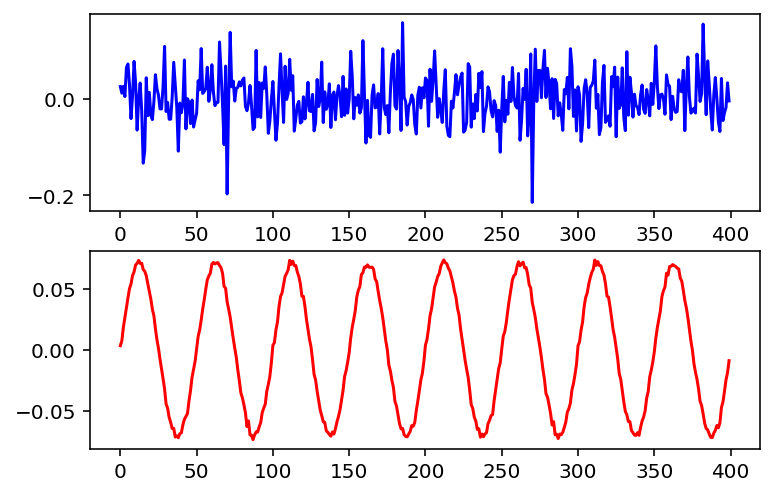

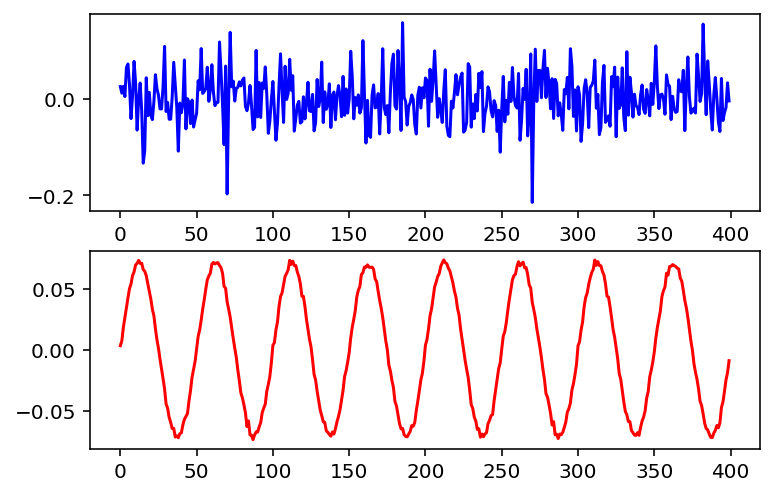

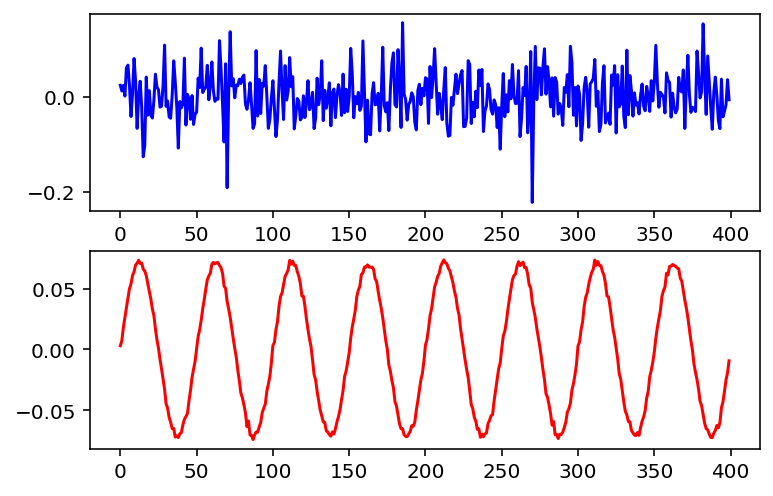

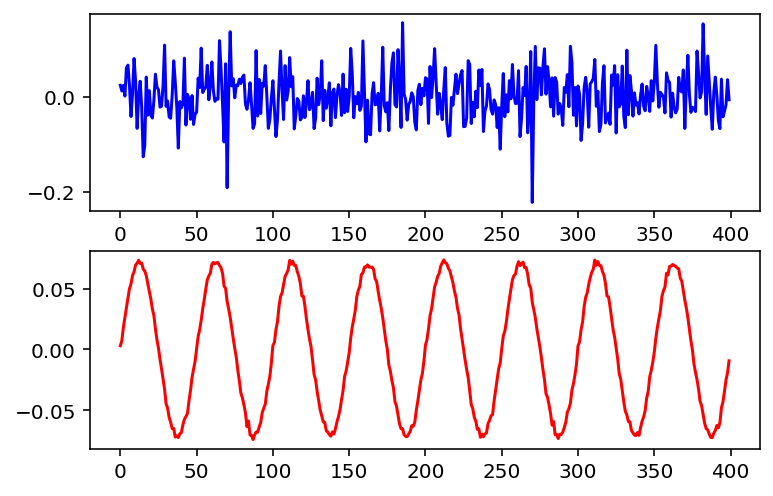

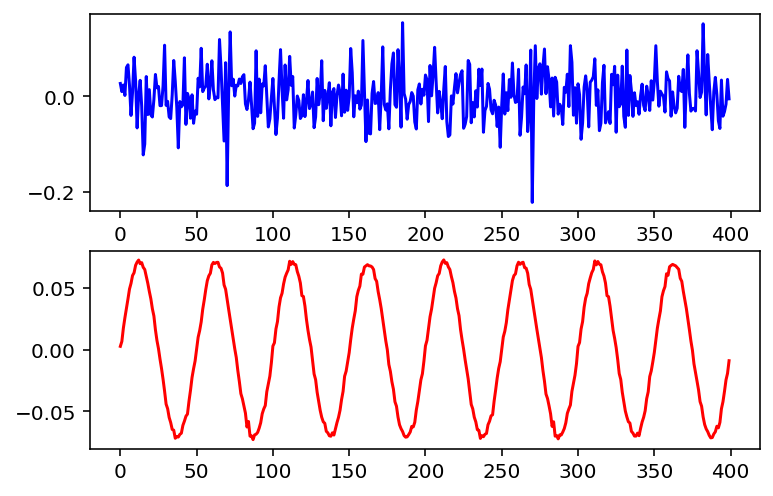

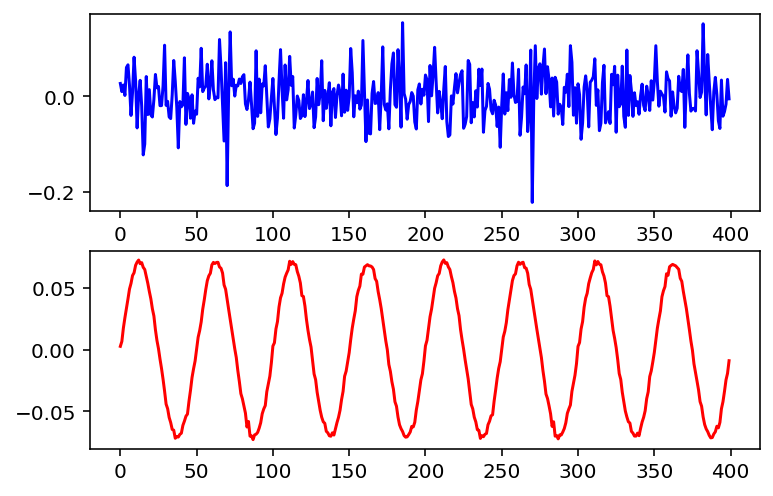

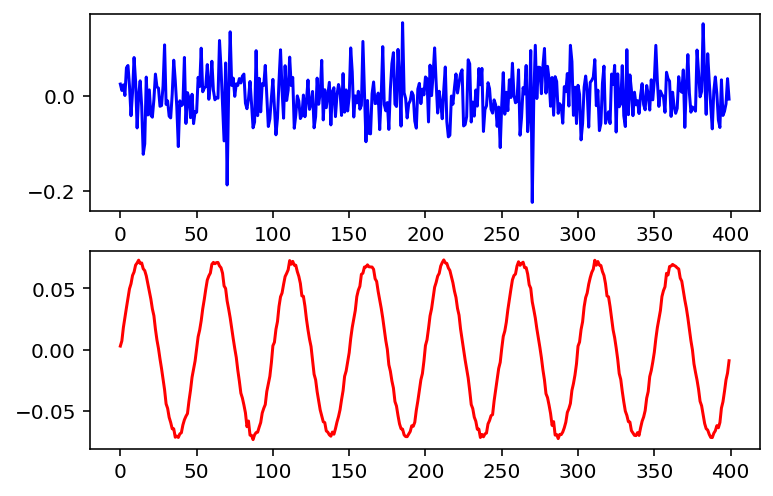

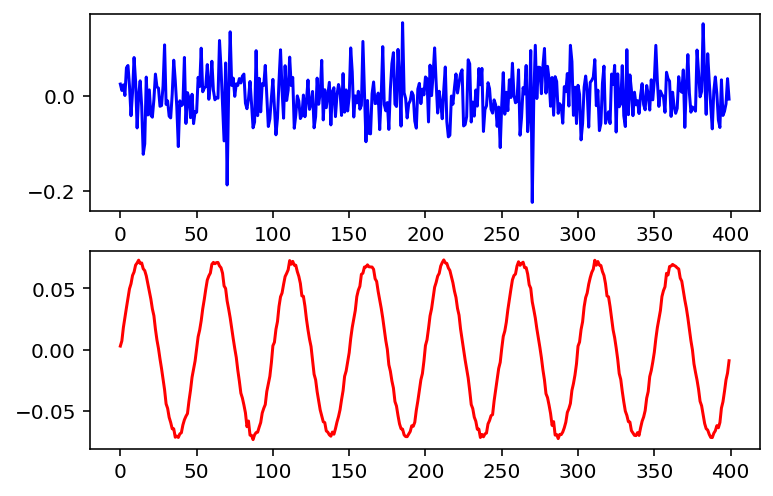

Done with training


In [46]:
n_iterations = 10000
codings = hidden
X_train = xmat.T
X_test = X_train

col = ['b','r','g','c','m','y','k']

sess = tf.InteractiveSession()
init.run()
    
for iteration in range(n_iterations):
    training_op.run(feed_dict={X: X_train})

    if iteration %1000 == 0:
        W_val = W.eval()
        plt.clf()
        for k in range(n_hidden):
            plt.subplot(n_hidden,1,k+1)
            plt.plot(W_val[:,k],col[k % len(col)])
        plt.show(False)
        plt.pause(0.001)

codings_val = codings.eval(feed_dict={X: X_test})

print("Done with training")

##### Question 1 (20 points)

What is an autoencoder? Please explain briefly. What would happen (ideally) if you pass a portion of signal x through the trained network?

--------- Brief explanation-------------------------------------------------------------------------------

- Autoencoder (special type of neural network) converts inputs to internal shorthand, then returns best-guess similarity. Two parts: encoder (recognizer) & decoder (generator, aka reconstructor).

- Reconstruction loss - penalizes model when reconstructions != inputs.
- Internal representation = lower dimensionality, so autencoder is forced to learn most important features in inputs


Ideally, if you pass a portion of signal x through the trained network, we should be able to reconstruct the portion of signal x identical to the original. However, in practice, we end up getting something very similar to input signal x, but not exact. The process of an encoder is illustrated in the image below. (You can also denoise a signal and get it close to a pure signal.)




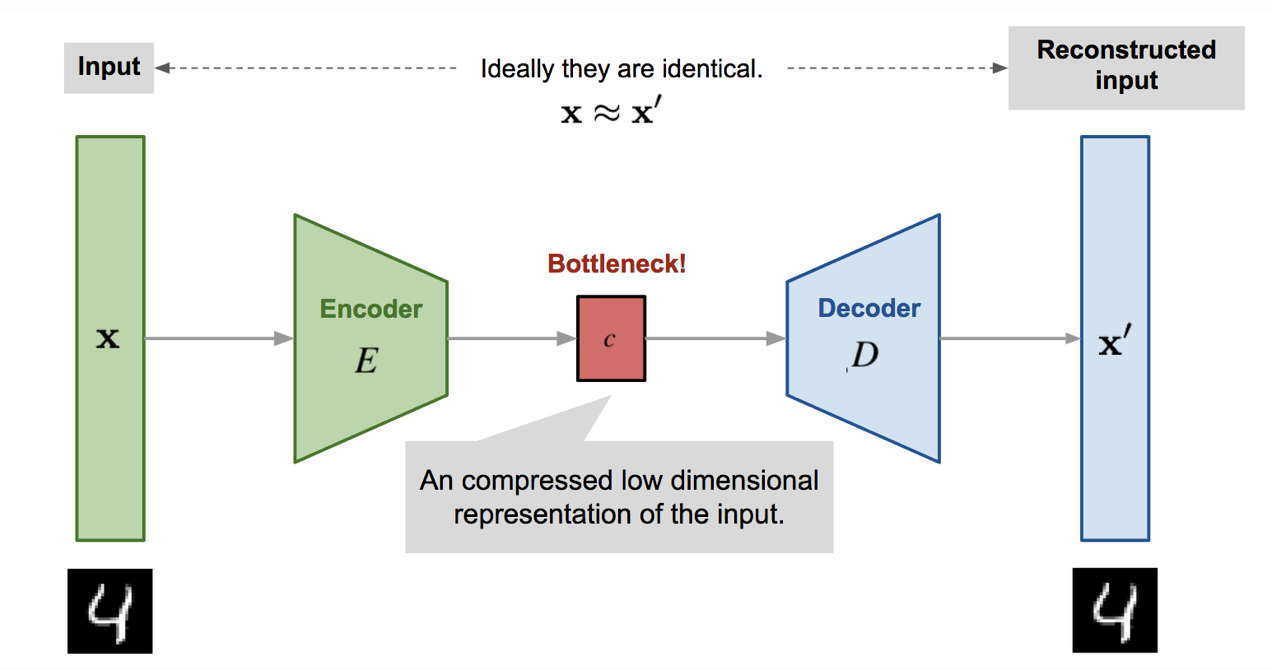

##### Question 2 (10 points)

Based on the observed shape of n_inputs and the definition of X_train, what exactly is being passed to the input layer of the network for a single forward pass? Be specific!

n_inputs represents 400 values (or x_mat[0] since its shape is 400 x 148) and X_train represents the matrix transpose of x_mat which is 148x400. So we have a 148 dimension dataset and we are passing a single 148 array/vector for each single forward pass. This is given from the placeholder and the following code:


- for iteration in range(10000):
    training_op.run(feed_dict={X: X_train})
    
   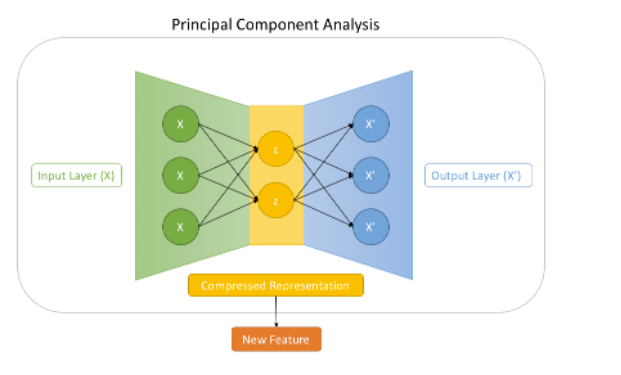
   
   So corresponding with our input, there are 400 X's consisting of dimension 148 that are being compressed onto the lower (2) dimensional representation of the input(Z in the figure)


##### Question 3 (10 points)

What variable(s) are used to represent the network weights? How are these weights initialized prior to training?

```
- W = tf.Variable(tf.truncated_normal(stddev=.1, shape =[n_inputs,n_hidden]))

Variable W represents the network weights. The weight variable is initialized with a truncated normal distribution of standard deviation 0.1 and of shape (400,2) which is the shape of the inputs by  the 2 hidden layers, so the function selects 800 samples from a truncated normal distributions(mean 0) and values range from from -.1 to .1 ```

##### Question  4 (10 points)

What is being minimized in the reconstruction loss? Why is this helpful?

- reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

Mean squared error is the function used in our example(mean squared error reconstruction loss). In general, a loss function reduces the difference between the predicted output and the actual output.  This is helpful beacause the loss function penalizes the reconstruction for being dissimilar to the input and we are seeking to minimize the gap between the input data and its reconstruction by measuring and miminizing the difference between the estimated values and actual values. Again, to learn the neuron weights and, thus the codings (two hidden layers in our example), the autoencoder seeks to minimize the loss function,  mean squared error (MSE), that penalizes $ minimize$ $ L = f(X, X')$



##### Question 5 (10 points)

What is an optimizer? What are 3 common optimizers? Which optimizer is used in this AE training? 

Optimizers reduce the error of the loss function (MSE in our code) by updating the weight(s) (finding the optimzed value for the weights) in the back propogation. Three common optimizers are ...
1. gradient descent (an iterative ML optimization algorithm to reduce the loss function)
2. stochastic gradient descent(SGD)- (like its name, a stochastic approximation of gradient descent since it replaces the actual gradient with an estimate) 
3. ADAM (an adaptive moment estimation algorithm that works on the method of computing adaptive learning rates for each parameter at every iteration and is esentially a further extension of stochastic gradient descent to update network weights furing training).

The optimzer we used in our undercomplete linear autoencoder is Adam (an adaptive moment estimation). 


- optimizer = tf.train.AdamOptimizer(learning_rate)
- training_op = optimizer.minimize(reconstruction_loss)

We can examine now the "codings", i.e. the hidden unit values and their distribution. The more signigicant codings should have smaller variances.

mean:  [-0.19275917 14.1111    ]
variance [0.77875865 0.28293753]


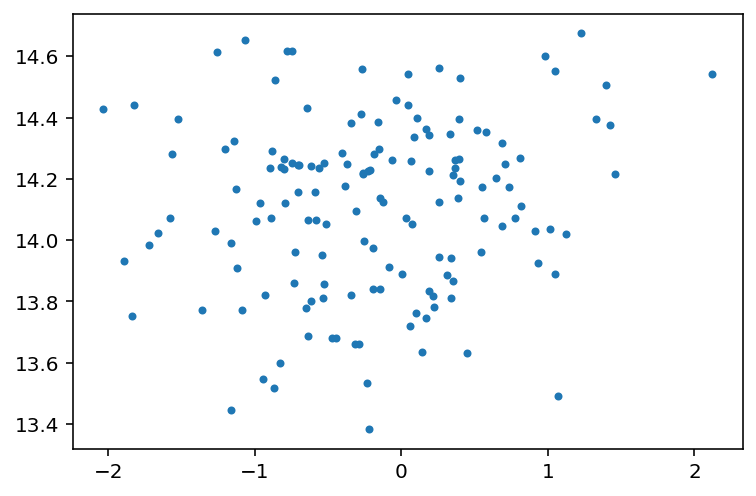

In [48]:
plt.plot(codings_val[:,0],codings_val[:,1],'.')
print ("mean: ", np.mean(codings_val,0))
print ("variance", np.std(codings_val,0));

###### Question 6 (10 points)

In what way does the autoencoder network function similarly to PCA?

```The main applications of autoencoders is dimensionality reductions, just like Principal Component Analysis(PCA).PCA is restricted to a linear map, while autoencoders can have nonlinear enoder/decoders.When the decoder is linear and L (the loss function) is mean squared error, an undercomplete autoencoder learns  to span the same subspace as PCA. (In this case the autoencoder trained to perform the copying task has learned the principal subspace of the training data as a side-effect).```

##### PCA versus AE (30 points)

Using sklearn.decomposition.PCA (or another PCA implementation in Python), illustrate the ideas you discuss in Question 1 & Question 7. You should have two plots: one showing the output of the AE network on a single sample, and another showing the output of your PCA on the same sample. How many principal components do you use in your reconstruction to achieve similar performance to the AE network? 


Three principal components in the AE network

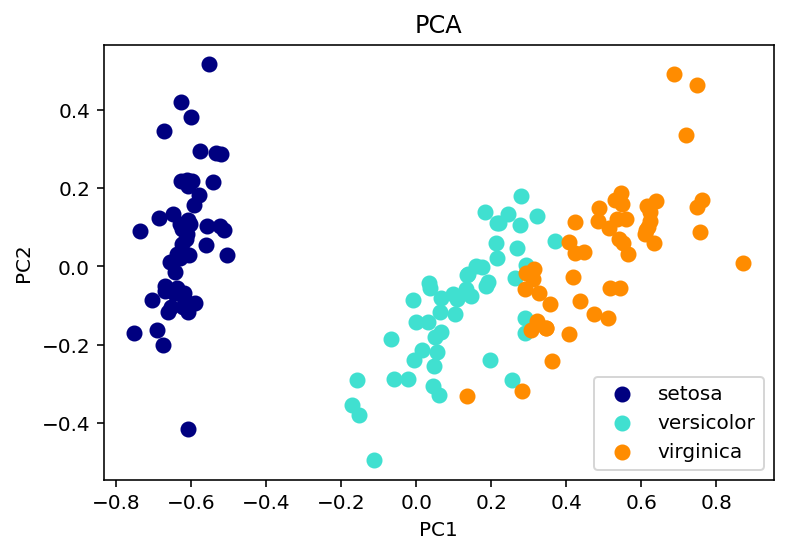

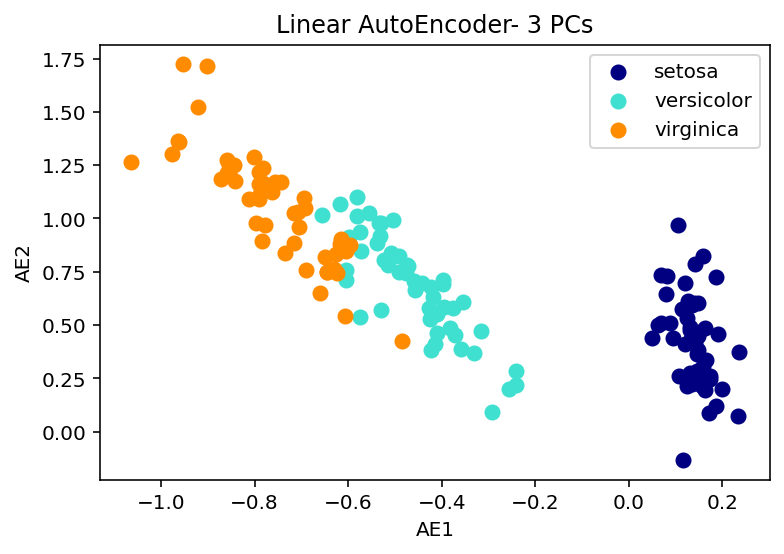

In [12]:
'''
Your code & plots here. 
Please make sure the number of principal components used is clear from your code.
'''

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler

    
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

def plot3clusters(X, title, vtitle):
  plt.figure()
  colors = ['navy', 'turquoise', 'darkorange']
  lw = 2

  for color, i, target_name in zip(colors, [0, 1, 2], target_names):
      plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=1., lw=lw,
                  label=target_name)
  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title(title)  
  plt.xlabel(vtitle + "1")
  plt.ylabel(vtitle + "2")
  plt.show()

####PCA

from sklearn import decomposition
pca = decomposition.PCA()
pca_transformed = pca.fit_transform(X_scaled)
plot3clusters(pca_transformed[:,:2], 'PCA', 'PC') 


from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt

#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim = X_scaled.shape[1]
encoding_dim = 2  
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_img)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')


history = autoencoder.fit(X_scaled, X_scaled,
                epochs=1000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

# use our encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(X_scaled)

plot3clusters(encoded_data[:,:2], 'Linear AutoEncoder- 3 PCs', 'AE')
